# IT9 Neutral ( >10 words) & ( >1.0 thumbsup)

Coding was developed based on below sources:
* Brandonrose.org. (2018). Document Clustering with Python. [online] Available at: http://brandonrose.org/clustering 
* Scikit-learn.org. (2018). sklearn.metrics.silhouette_score — scikit-learn 0.19.2 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
* Twitterdev.github.io. (2018). Do More with Twitter Data — Do more with Twitter data 0.1 documentation. [online] Available at: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import mpld3
import sys
import csv
import string

In [2]:
dsa_data = pd.read_csv('/Users/rmhiwku/depression-stress-anxiety.csv')
dsa_data = dsa_data.dropna() #filter out empty rows; otherwise it will fail later
dsa_data.columns = ['appname', 'rating', 'ratingcount', 'developer','apptype','reviewer','date','reviewer_rating','thumbsup','review']
dsa_data['words'] = dsa_data['review'].str.split()
dsa_data['word_len'] = dsa_data['words'].str.len()
print('Total reviews: ',len(dsa_data))

#filter in only neutral reviews >5 words
dsa_neutral = dsa_data[(dsa_data.reviewer_rating==3)&(dsa_data.word_len>8)&(dsa_data.thumbsup>1.0)]
print('Total neutral reviews >5 words: ', len(dsa_neutral))

#filter in only neutral reviews >10 words
dsa_neutral = dsa_data[(dsa_data.reviewer_rating==3)&(dsa_data.word_len>13)&(dsa_data.thumbsup>1.0)]
print('Total neutral reviews >10 words: ', len(dsa_neutral))

print()
#dsa_neutral.head()

Total reviews:  63474
Total neutral reviews >5 words:  633
Total neutral reviews >10 words:  596



In [3]:
#examine the data

dsa_neutral.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 142 to 63484
Data columns (total 12 columns):
appname            596 non-null object
rating             596 non-null float64
ratingcount        596 non-null object
developer          596 non-null object
apptype            596 non-null object
reviewer           596 non-null object
date               596 non-null object
reviewer_rating    596 non-null float64
thumbsup           596 non-null float64
review             596 non-null object
words              596 non-null object
word_len           596 non-null int64
dtypes: float64(3), int64(1), object(8)
memory usage: 60.5+ KB


In [4]:
#create lists of filtered neutral reviews
neu_apps = dsa_neutral['appname'].tolist()
neu_reviews = dsa_neutral['review'].tolist()

# Data Cleaning

In [5]:
# load NLTK's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['review','text','app',"also","would","stress","anxiety","depression","saying"]
stopwords.extend(newStopWords)
print (stopwords[:-1])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
# load NLTK's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]    
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [8]:
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in neu_reviews:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'review_texts', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

print("Number of vocab tokenized and stemmed: ", len(totalvocab_stemmed))
print("Number of vocab tokenized only: ",len(totalvocab_tokenized))

Number of vocab tokenized and stemmed:  12879
Number of vocab tokenized only:  12879


In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 12879 items in vocab_frame


In [10]:
print (vocab_frame.head())

             words
complet  completed
initi      initial
phase        phase
yet            yet
updat       update


In [11]:
# Count frequency of words
from collections import Counter
list1=totalvocab_stemmed
counts = Counter(list1)
print(counts)

Counter({'use': 190, 'like': 189, 'medit': 151, 'get': 139, 'realli': 136, 'great': 124, 'time': 122, 'help': 118, 'good': 113, 'work': 104, 'one': 98, 'love': 97, 'need': 93, 'tri': 88, 'free': 86, 'pay': 85, 'could': 81, 'make': 79, 'want': 75, 'peopl': 73, 'listen': 72, 'day': 70, 'subscript': 68, 'fix': 61, 'even': 59, 'feel': 58, 'thing': 58, 'month': 57, 'way': 56, 'much': 55, 'new': 52, 'option': 52, 'give': 50, 'still': 49, 'back': 48, 'start': 48, 'howev': 47, 'think': 47, 'pleas': 47, 'updat': 44, 'find': 44, 'better': 44, 'lot': 44, 'phone': 44, 'screen': 43, 'abl': 42, 'keep': 41, 'problem': 41, 'seem': 41, 'know': 41, 'messag': 41, 'track': 40, 'star': 40, 'chang': 40, 'idea': 39, 'featur': 39, 'issu': 39, 'set': 38, 'crash': 37, 'first': 37, 'stop': 37, 'well': 36, 'nice': 36, 'everi': 36, 'content': 36, 'guid': 36, 'mani': 36, 'therapist': 35, 'voic': 35, 'though': 34, 'without': 33, 'access': 33, 'rate': 33, 'money': 33, 'frustrat': 32, 'see': 32, 'wish': 32, 'open': 32

# Tfidf Vectorizer

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.01, stop_words=stopwords,
                                   use_idf=True,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(neu_reviews) #fit the vectorizer to review_texts

print(tfidf_matrix.shape)

Wall time: 620 ms
(596, 457)


In [13]:
# Etermining what terms are useful enough to turn into features
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
terms

457


['abil',
 'abl',
 'access',
 'account',
 'accur',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'afford',
 'age',
 'ago',
 'allow',
 'almost',
 'alot',
 'alreadi',
 'alway',
 'amaz',
 'amount',
 'android',
 'annoy',
 'anoth',
 'answer',
 'anymor',
 'anyon',
 'anyth',
 'applic',
 'area',
 'around',
 'ask',
 'avail',
 'away',
 'awesom',
 'back',
 'background',
 'bad',
 'basic',
 'becom',
 'begin',
 'benefit',
 'best',
 'better',
 'big',
 'bit',
 'block',
 'bought',
 'break',
 'breath',
 'broken',
 'bug',
 'button',
 'buy',
 'calm',
 'cant',
 'care',
 'categori',
 'caus',
 'certain',
 'chanc',
 'chang',
 'charg',
 'chat',
 'check',
 'choos',
 'clear',
 'click',
 'close',
 'color',
 'come',
 'comment',
 'compar',
 'complet',
 'concept',
 'connect',
 'consid',
 'constant',
 'contact',
 'content',
 'continu',
 'correct',
 'cost',
 'could',
 'coupl',
 'crash',
 'creat',
 'cup',
 'current',
 'custom',
 'daili',
 'data',
 'day',
 'deal',
 'definit',
 'delet',
 'depress',
 'design',
 'develop',

In [14]:
# dist is defined as 1 - the cosine similarity of each document. 
# Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity 
# between each document and the other documents in the corpus (each review among the reviews). 
# Subtracting it from 1 provides cosine distance which is used for plotting on a euclidean (2-dimensional) plane.
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

Wall time: 292 ms


# K-means clustering

In [15]:
import pandas
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Elbow Curve - Finding the best parameter 

Wall time: 3min 58s


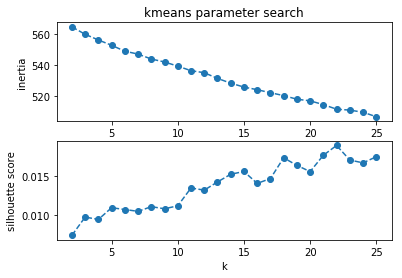

In [16]:
%%time

import logging
from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

For n_clusters = 8 The average silhouette_score is : 0.007354741177143076


For n_clusters = 8 The average silhouette_score is : 0.009698138163413764


For n_clusters = 8 The average silhouette_score is : 0.009396170937988084


For n_clusters = 8 The average silhouette_score is : 0.010904591237726661


For n_clusters = 8 The average silhouette_score is : 0.010670745795771873


For n_clusters = 8 The average silhouette_score is : 0.010438889732069221
For n_clusters = 8 The average silhouette_score is : 0.011039840031859434
Wall time: 1min 10s


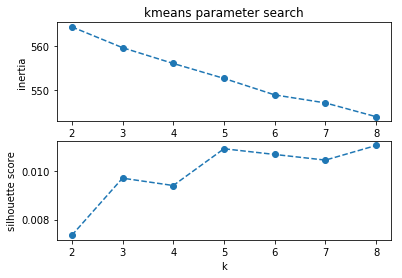

In [38]:
%%time

import logging
from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2, 3, 4, 5, 6, 7, 8]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)
    silhouette_avg = silhouette_score(tfidf_matrix, labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)


plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

## (5 clusters) 

In [17]:
# Do KMeans clustering to get the clusters
#from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 726 ms


In [18]:
# Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle
joblib.dump(km,  'doc_cluster9-1.pkl')#JK NOTE:::::remember to change name

km = joblib.load('doc_cluster9-1.pkl')
clusters = km.labels_.tolist()

In [19]:
# Create dictionary
appreview = { 'review': neu_reviews, 'cluster': clusters}
frame = pd.DataFrame(appreview, index = [clusters] , columns = ['review','cluster'])

In [20]:
frame.to_csv("IT9-1Sample.csv")

In [21]:
#number of reviews per cluster (clusters from 0 to 4)
frame['cluster'].value_counts()

2    224
3    124
0    122
1     65
4     61
Name: cluster, dtype: int64

In [22]:
# indexing and sorting on each cluster to identify which are the top n (I used n=50) words that are nearest 
# to the cluster centroid. This gives a good sense of the main topic of the cluster.
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :50]: #replace with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        
    print() #add whitespace
    print() #add whitespace

print()

Top terms per cluster:

Cluster 0 words: use, good, love, time, stars, help, crashing, fix, add, records, started, phone, people, get, open, please, way, great, every, many, added, days, gives, keep, making, even, back, options, easy, idea, able, data, full, functional, offline, track, saved, still, new, nice, need, could, much, problem, however, week, let, posted, update, really,

Cluster 1 words: really, voice, like, sounded, relaxing, things, help, get, options, see, settings, wish, good, secondly, free, better, find, made, listening, stars, could, guys, love, great, concept, slow, phone, reading, making, first, idea, message, medition, use, problem, session, gives, notifications, nice, feel, looks, money, subscribed, sleep, enjoying, reminders, well, way, annoying, trying,

Cluster 2 words: listening, help, trying, like, get, need, great, one, people, know, time, feel, therapist, options, message, fix, could, please, days, better, making, think, chat, seems, talk, want, lot, issues

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


# Multidimensional scaling

In [24]:
# convert the dist matrix into a 2-dimensional array using multidimensional scaling (MDS)
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()

Wall time: 11.9 s



In [25]:
#save nparray
a = pos
np.savetxt("IT9-1POSnparray.csv", a, delimiter=",") ##JK note: remeber to change file name

# Visualizing document clusters

In [30]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#5B1B9E', 6: '#9E1B7E', 7: '#9E1B22', 8: '#969E1B', 9: '#D3F22F',
                  10: '#F2602F', 11: '#50C7F4', 12: '#8ECE92', 13: '#E79FC0', 14: '#74045E',
                  15: '#EC86DD', 16: '#508DF4', 17: '#F4EB10', 18: '#C94E86', 19: '#5C45A5',
                  20: '#F0D0EB', 21: '#109C19', 22: '#E7E59F', 23: '#740437', 24: '#1AAEC3'}

#set up cluster names using a dict
cluster_names = {0: 'cluster1', 
                 1: 'cluster2', 
                 2: 'cluster3',
                 3: 'cluster4',
                 4: 'cluster5'}

### First, define some dictionaries for going from cluster number to color and to cluster name. Then, based the cluster names off the words that were closest to each cluster centroid.

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


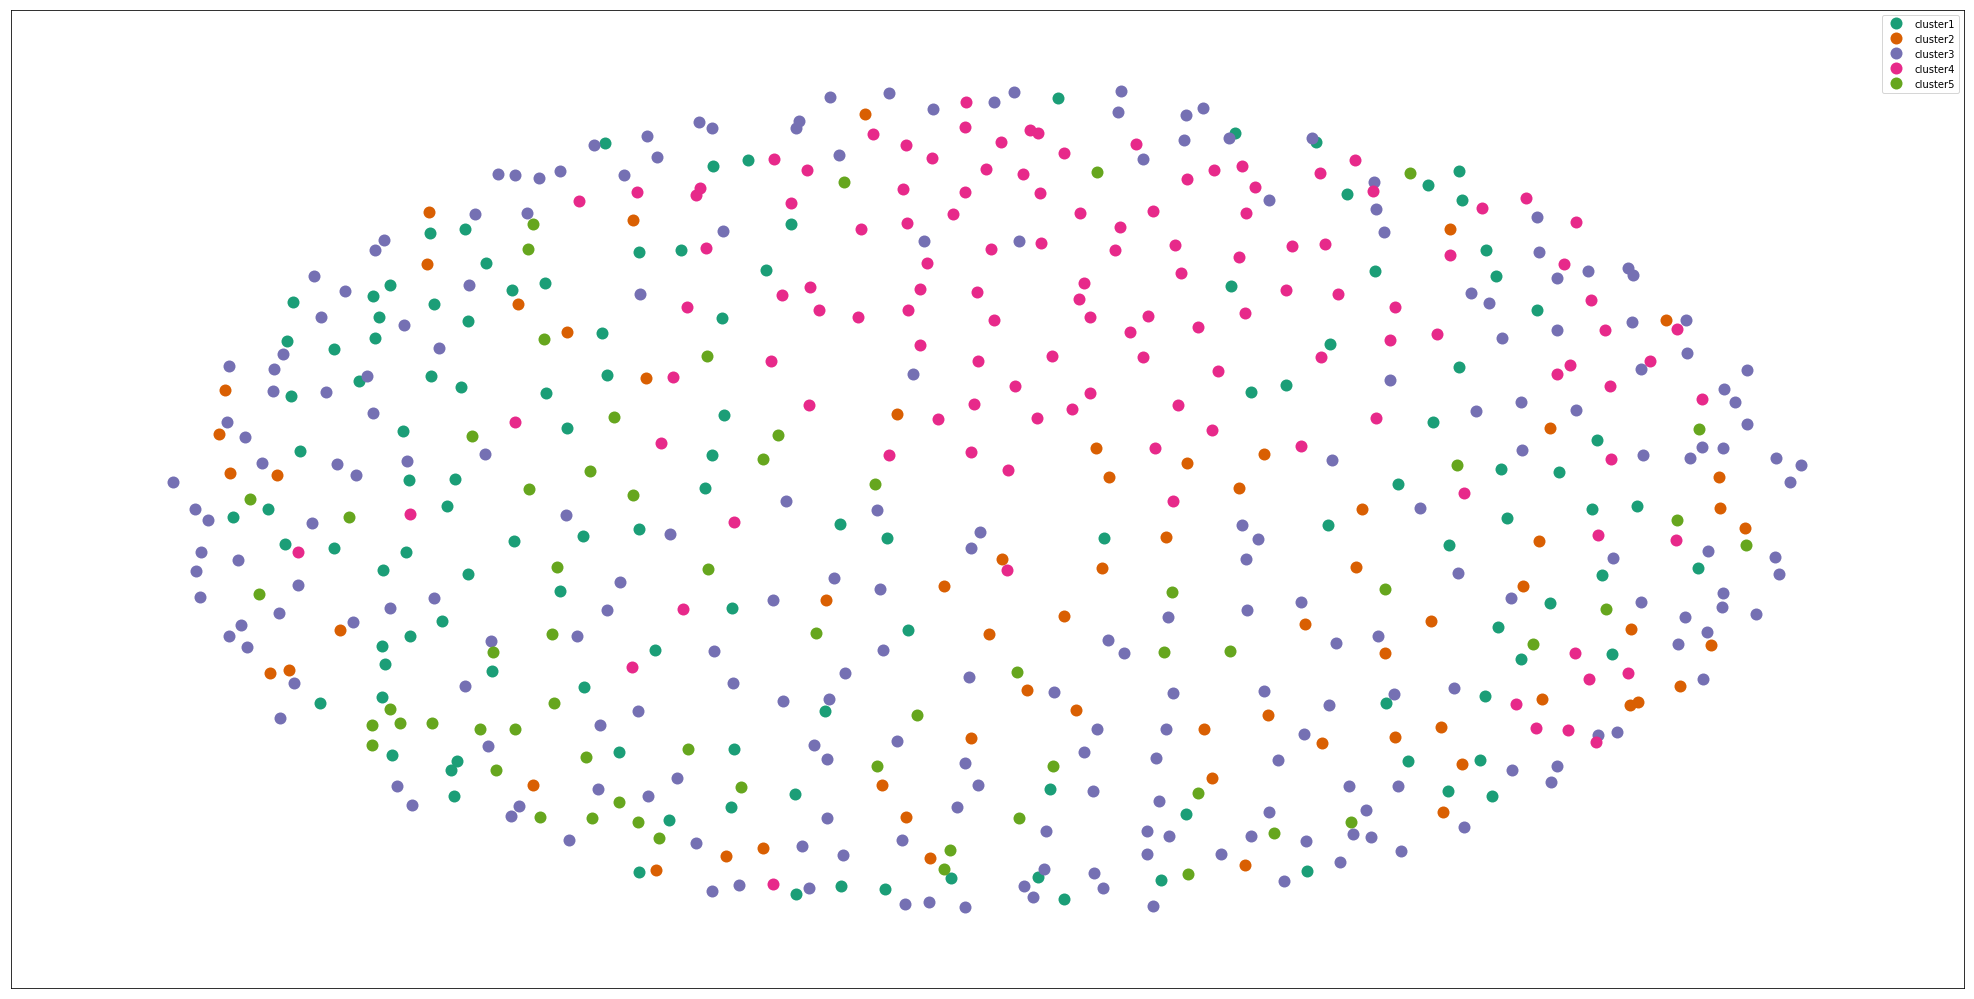

<Figure size 432x288 with 0 Axes>

In [32]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, review=neu_reviews)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(35, 18)) # set size
ax.margins(0.1) # add padding

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point


plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters.png', dpi=200)

In [ ]:
plt.close()